# 1. Setup

In [2]:
# Pytorch
!pip install -U torch torchvision
!pip install git+https://github.com/facebookresearch/fvcore.git
import torch, torchvision
torch.__version__

# Detectron2
!git clone https://github.com/facebookresearch/detectron2 detectron2_repo
!pip install -e detectron2_repo

Requirement already up-to-date: torch in /usr/local/lib/python3.6/dist-packages (1.3.0+cu100)
Requirement already up-to-date: torchvision in /usr/local/lib/python3.6/dist-packages (0.4.1+cu100)
  Cloning https://github.com/facebookresearch/fvcore.git to /tmp/pip-req-build-b2sxrzov
  Running command git clone -q https://github.com/facebookresearch/fvcore.git /tmp/pip-req-build-b2sxrzov
     |████████████████████████████████| 266kB 9.0MB/s 
  Created wheel for fvcore: filename=fvcore-0.1-cp36-none-any.whl size=46929 sha256=ab5dfd0d4b548a4e47f4d1395772af569e4ca43d2dd7fb9a94c0cd70cc1804b4
  Stored in directory: /tmp/pip-ephem-wheel-cache-r5mxng5_/wheels/48/53/79/3c6485543a4455a0006f5db590ab9957622b6227011941de06
  Created wheel for pyyaml: filename=PyYAML-5.1.2-cp36-cp36m-linux_x86_64.whl size=44104 sha256=2e65a9343f2cb440d9dcec3f5e831607b1ea3d440d8ae1e4d0a43cb82b8b6cde
  Stored in directory: /root/.cache/pip/wheels/d9/45/dd/65f0b38450c47cf7e5312883deb97d065e030c5cca0a365030
Successfully b

In [0]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import matplotlib.pyplot as plt
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
import re
import json
import os
import shutil
import torch
import random
from sklearn.model_selection import train_test_split
import importlib.util
import sys

# import some common detectron2 utilities
from detectron2.engine import DefaultPredictor
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.data.transforms import transform_gen, transform
from detectron2.data.detection_utils import transform_instance_annotations
from detectron2.data import build_detection_train_loader
from detectron2.structures import BoxMode

Define system paths and mount Drive

In [30]:
# System paths
main_path = "./drive/My Drive/safety/happy-walrus/"
model_path = main_path + "models/version_1/"
train_annots_path = os.path.join(model_path, 'data/training/coco_annotations.json')
train_imgs_path = os.path.join(model_path, 'data/training/images/')
valid_annots_path = os.path.join(model_path, 'data/validation/coco_annotations.json')
valid_imgs_path = os.path.join(model_path, 'data/validation/images/')

# Mount Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# 2. Data preparation

See [Data preparation notebook](https://drive.google.com/open?id=1eDunoy1c7dWSdsNTobK6RPILEF-e1fhs).

### Register data

Register datasets

In [31]:
# Register training
register_coco_instances("train_data", {}, train_annots_path, train_imgs_path)
MetadataCatalog.get("train_data").thing_classes = ["stove/oven", "chair"]
test_metadata = MetadataCatalog.get("train_data")
dataset_dicts = DatasetCatalog.get("train_data")

# Register validation
register_coco_instances("valid_data", {}, valid_annots_path, valid_imgs_path)
MetadataCatalog.get("valid_data").thing_classes = ["stove/oven", "chair"]
valid_metadata = MetadataCatalog.get("valid_data")
valid_dataset_dicts = DatasetCatalog.get("valid_data")

[10/25 15:24:24 d2.data.datasets.coco]: Loaded 2398 images in COCO format from ./drive/My Drive/safety/happy-walrus/models/version_1/data/training/coco_annotations.json
[10/25 15:24:24 d2.data.datasets.coco]: Loaded 267 images in COCO format from ./drive/My Drive/safety/happy-walrus/models/version_1/data/validation/coco_annotations.json


Verify data is loaded correctly

./drive/My Drive/safety/happy-walrus/models/version_1/data/training/images/ADE_train_00010622.jpg


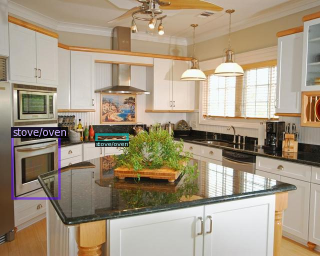

./drive/My Drive/safety/happy-walrus/models/version_1/data/training/images/clean_kitchen.NM.076.jpg


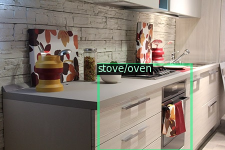

./drive/My Drive/safety/happy-walrus/models/version_1/data/training/images/ADE_train_00010599.jpg


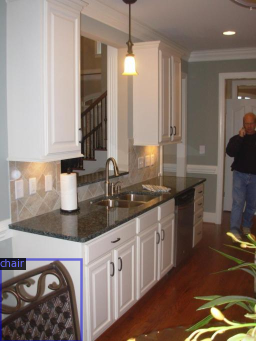

In [4]:
for d in random.sample(dataset_dicts, 3):
    print(d['file_name'])
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=test_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

### Test transformers

Test transformer with sample image.

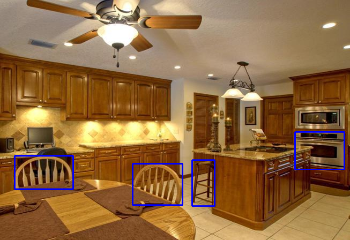

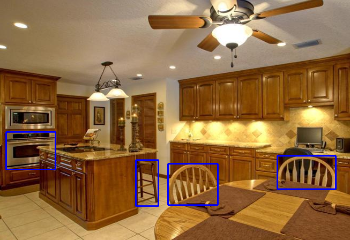

In [5]:
import copy

# draw boxes function
def draw_bboxes(annotations, image):
  for anno in annotations:
    x1 = anno['bbox'][0]
    y1 = anno['bbox'][1]
    if str(anno['bbox_mode']) == 'BoxMode.XYWH_ABS':
      x2 = x1 + anno['bbox'][2]
      y2 = y1 + anno['bbox'][3]
    else:
      x2 = anno['bbox'][2]
      y2 = anno['bbox'][3]
    cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 2)
    
# Original image
test_dict = copy.deepcopy(dataset_dicts[0])
img = cv2.imread(test_dict['file_name'])

anno1 = test_dict['annotations'][0]
anno2 = test_dict['annotations'][1]
anno3 = test_dict['annotations'][2]
anno4 = test_dict['annotations'][3]
annots = [anno1, anno2, anno3, anno4]

draw_bboxes(annots, img)
cv2_imshow(cv2.resize(img, (350, 240)))

# Flipped image
hflipper = transform_gen.RandomFlip(prob=1)
img = cv2.imread(test_dict['file_name'])
img_hflipper = hflipper.get_transform(img)

img_hflipped = img_hflipper.apply_image(img)
w = test_dict['width']
h = test_dict['height']
anno1_hf = transform_instance_annotations(anno1, img_hflipper, (h, w))
anno2_hf = transform_instance_annotations(anno2, img_hflipper, (h, w))
anno3_hf = transform_instance_annotations(anno3, img_hflipper, (h, w))
anno4_hf = transform_instance_annotations(anno4, img_hflipper, (h, w))
annots_hf = [anno1_hf, anno2_hf, anno3_hf, anno4_hf]

draw_bboxes(annots_hf, img_hflipped)
cv2_imshow(cv2.resize(img_hflipped, (350, 240)))

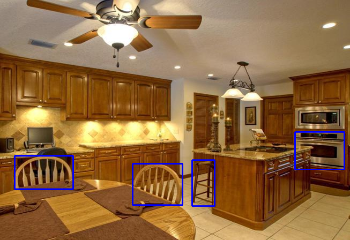

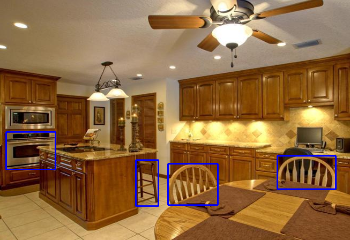

In [0]:
def draw_bboxes2(annotations, image):
  for annotation in annotations:
    bbox_xy = BoxMode.convert(annotation["bbox"], annotation["bbox_mode"], BoxMode.XYXY_ABS)
    bbox_xy = img_hflipper.apply_box(bbox_xy)[0]
    x1 = bbox_xy[0]
    y1 = bbox_xy[1]
    x2 = bbox_xy[2]
    y2 = bbox_xy[3]
    cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 2)

# Original image
test_dict = copy.deepcopy(dataset_dicts[0])
img = cv2.imread(test_dict['file_name'])

anno1 = test_dict['annotations'][0]
anno2 = test_dict['annotations'][1]
anno3 = test_dict['annotations'][2]
anno4 = test_dict['annotations'][3]
annots = [anno1, anno2, anno3, anno4]

draw_bboxes(annots, img)
cv2_imshow(cv2.resize(img, (350, 240)))

# Flip image
hflipper = transform_gen.RandomFlip(prob=1)
img = cv2.imread(test_dict['file_name'])
img_hflipper = hflipper.get_transform(img)
img_hf = img_hflipper.apply_image(img)

# Flip bbox
w = test_dict['width']
h = test_dict['height']
draw_bboxes2(annots, img_hf)
cv2_imshow(cv2.resize(img_hf, (350, 240)))

# 3. Model training

### Model training (default mapper, no augmentations)

Retrain model

If the following error is returned `RuntimeError: cuda runtime error (38) : no CUDA-capable device is detected at /pytorch/aten/src/THC/THCGeneral.cpp:50`, go to Runtime -> Change Runtime Type, and select GPU accelerated option.

In [20]:
cfg = get_cfg()
cfg.merge_from_file("./detectron2_repo/configs/COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")
cfg.DATASETS.TRAIN = ("train_data",)
# cfg.DATASETS.TEST = ("valid_data",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.MASK_ON = False

cfg.MODEL.WEIGHTS = "detectron2://COCO-Detection/faster_rcnn_R_50_FPN_3x/137849458/model_final_280758.pkl"
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 300    # 300 iterations seems good enough, but you can certainly train longer

cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2
cfg.OUTPUT_DIR = model_path + 'output_defaults'
cfg.SEED = 2000

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

WARNING [10/25 02:25:58 d2.config.compat]: Config './detectron2_repo/configs/COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml' has no VERSION. Assuming it to be compatible with latest v2.
[10/25 02:25:58 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv

'roi_heads.box_predictor.cls_score.weight' has shape (81, 1024) in the checkpoint but (3, 1024) in the model! Skipped.
'roi_heads.box_predictor.cls_score.bias' has shape (81,) in the checkpoint but (3,) in the model! Skipped.
'roi_heads.box_predictor.bbox_pred.weight' has shape (320, 1024) in the checkpoint but (8, 1024) in the model! Skipped.
'roi_heads.box_predictor.bbox_pred.bias' has shape (320,) in the checkpoint but (8,) in the model! Skipped.


[10/25 02:25:59 d2.engine.train_loop]: Starting training from iteration 0
[10/25 02:26:26 d2.utils.events]: eta: 0:06:20  iter: 19  total_loss: 1.921  loss_cls: 1.252  loss_box_reg: 0.537  loss_rpn_cls: 0.045  loss_rpn_loc: 0.019  time: 1.3712  data_time: 0.0202  lr: 0.000005  max_mem: 3686M
[10/25 02:26:51 d2.utils.events]: eta: 0:05:41  iter: 39  total_loss: 1.914  loss_cls: 1.166  loss_box_reg: 0.635  loss_rpn_cls: 0.042  loss_rpn_loc: 0.012  time: 1.3158  data_time: 0.0046  lr: 0.000010  max_mem: 3686M
[10/25 02:27:17 d2.utils.events]: eta: 0:05:12  iter: 59  total_loss: 1.674  loss_cls: 0.995  loss_box_reg: 0.605  loss_rpn_cls: 0.053  loss_rpn_loc: 0.020  time: 1.3067  data_time: 0.0042  lr: 0.000015  max_mem: 3686M
[10/25 02:27:44 d2.utils.events]: eta: 0:04:47  iter: 79  total_loss: 1.494  loss_cls: 0.844  loss_box_reg: 0.626  loss_rpn_cls: 0.064  loss_rpn_loc: 0.025  time: 1.3105  data_time: 0.0048  lr: 0.000020  max_mem: 3686M
[10/25 02:28:10 d2.utils.events]: eta: 0:04:21  it

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 10. 
  warnings.warn(str(msg))


[10/25 02:28:36 d2.utils.events]: eta: 0:03:54  iter: 119  total_loss: 1.253  loss_cls: 0.566  loss_box_reg: 0.578  loss_rpn_cls: 0.035  loss_rpn_loc: 0.018  time: 1.3053  data_time: 0.0040  lr: 0.000030  max_mem: 3686M
[10/25 02:29:01 d2.utils.events]: eta: 0:03:27  iter: 139  total_loss: 1.332  loss_cls: 0.532  loss_box_reg: 0.658  loss_rpn_cls: 0.059  loss_rpn_loc: 0.021  time: 1.2978  data_time: 0.0039  lr: 0.000035  max_mem: 3686M
[10/25 02:29:27 d2.utils.events]: eta: 0:03:02  iter: 159  total_loss: 1.149  loss_cls: 0.455  loss_box_reg: 0.639  loss_rpn_cls: 0.031  loss_rpn_loc: 0.014  time: 1.2973  data_time: 0.0038  lr: 0.000040  max_mem: 3686M
[10/25 02:29:53 d2.utils.events]: eta: 0:02:37  iter: 179  total_loss: 0.991  loss_cls: 0.399  loss_box_reg: 0.553  loss_rpn_cls: 0.048  loss_rpn_loc: 0.010  time: 1.3014  data_time: 0.0037  lr: 0.000045  max_mem: 3686M
[10/25 02:30:20 d2.utils.events]: eta: 0:02:11  iter: 199  total_loss: 1.082  loss_cls: 0.394  loss_box_reg: 0.552  loss

OrderedDict()

### Model training (custom mapper, no augmentations)

Modify following modules:
- `defaults.py -> custom_defaults.py`: `DefaultTrainer()`'s `__init__` takes a `loader` argument.
- `dataset_mapper.py -> custom_dataset_mapper.py`: no modifications, only for testing now.

Setup config object

In [32]:
cfg1 = get_cfg()
cfg1.merge_from_file("./detectron2_repo/configs/COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")
cfg1.DATASETS.TRAIN = ("train_data",)
cfg1.DATASETS.TEST = () 
cfg1.DATALOADER.NUM_WORKERS = 2
cfg1.MODEL.MASK_ON = False

cfg1.MODEL.WEIGHTS = "detectron2://COCO-Detection/faster_rcnn_R_50_FPN_3x/137849458/model_final_280758.pkl"
cfg1.SOLVER.IMS_PER_BATCH = 2
cfg1.SOLVER.BASE_LR = 0.00025
cfg1.SOLVER.MAX_ITER = 300

cfg1.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg1.MODEL.ROI_HEADS.NUM_CLASSES = 2
cfg1.OUTPUT_DIR = model_path + 'output_basic_custom_mapper'
cfg1.SEED = 2000

WARNING [10/25 15:24:37 d2.config.compat]: Config './detectron2_repo/configs/COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml' has no VERSION. Assuming it to be compatible with latest v2.


Train model

In [34]:
# Import custom dataset mapper
spec_dataset_mapper = importlib.util.spec_from_file_location("custom_dataset_mapper",
                                                             model_path + 'modules/custom_dataset_mapper.py')
custom_dataset_mapper = importlib.util.module_from_spec(spec_dataset_mapper)
spec_dataset_mapper.loader.exec_module(custom_dataset_mapper)

# Import custom default trainer
spec_defaults = importlib.util.spec_from_file_location("custom_defaults",
                                                       model_path + 'modules/custom_defaults.py')
custom_defaults = importlib.util.module_from_spec(spec_defaults)
spec_defaults.loader.exec_module(custom_defaults)

# Define data mapper, loader and trainer
mapper1 = custom_dataset_mapper.DatasetMapper(cfg1)
loader1 = build_detection_train_loader(cfg1, mapper1)
trainer1 = custom_defaults.DefaultTrainer(cfg1, loader1)

# Train model
os.makedirs(cfg1.OUTPUT_DIR, exist_ok=True)
trainer1.resume_or_load(resume=False)
trainer1.train()

[10/25 15:24:42 d2.data.detection_utils]: TransformGens used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[10/25 15:24:42 d2.data.datasets.coco]: Loaded 2398 images in COCO format from ./drive/My Drive/safety/happy-walrus/models/version_1/data/training/coco_annotations.json
[10/25 15:24:42 d2.data.build]: Removed 153 images with no usable annotations. 2245 images left.
[10/25 15:24:42 d2.data.build]: Using training sampler TrainingSampler


model_final_280758.pkl: 167MB [00:14, 11.2MB/s]                           
'roi_heads.box_predictor.cls_score.weight' has shape (81, 1024) in the checkpoint but (3, 1024) in the model! Skipped.
'roi_heads.box_predictor.cls_score.bias' has shape (81,) in the checkpoint but (3,) in the model! Skipped.
'roi_heads.box_predictor.bbox_pred.weight' has shape (320, 1024) in the checkpoint but (8, 1024) in the model! Skipped.
'roi_heads.box_predictor.bbox_pred.bias' has shape (320,) in the checkpoint but (8,) in the model! Skipped.


[10/25 15:24:59 d2.engine.train_loop]: Starting training from iteration 0
[10/25 15:25:21 d2.utils.events]: eta: 0:05:04  iter: 19  total_loss: 1.762  loss_cls: 1.072  loss_box_reg: 0.630  loss_rpn_cls: 0.033  loss_rpn_loc: 0.021  time: 1.1073  data_time: 0.0042  lr: 0.000005  max_mem: 2842M
[10/25 15:25:45 d2.utils.events]: eta: 0:05:19  iter: 39  total_loss: 1.662  loss_cls: 0.996  loss_box_reg: 0.605  loss_rpn_cls: 0.042  loss_rpn_loc: 0.016  time: 1.1600  data_time: 0.0039  lr: 0.000010  max_mem: 3055M
[10/25 15:26:08 d2.utils.events]: eta: 0:04:35  iter: 59  total_loss: 1.575  loss_cls: 0.882  loss_box_reg: 0.675  loss_rpn_cls: 0.053  loss_rpn_loc: 0.017  time: 1.1477  data_time: 0.0049  lr: 0.000015  max_mem: 3055M
[10/25 15:26:29 d2.utils.events]: eta: 0:04:10  iter: 79  total_loss: 1.525  loss_cls: 0.738  loss_box_reg: 0.719  loss_rpn_cls: 0.057  loss_rpn_loc: 0.021  time: 1.1263  data_time: 0.0077  lr: 0.000020  max_mem: 3055M
[10/25 15:26:52 d2.utils.events]: eta: 0:03:49  it

OrderedDict()

### Model training (custom mapper, custom augmentations)

Test albumentations (postponed)

In [35]:
!pip install albumentations

     |████████████████████████████████| 634kB 6.3MB/s 
  Created wheel for imgaug: filename=imgaug-0.2.6-cp36-none-any.whl size=654020 sha256=cb0d066bc11d16f629e03b3f7da1d5c3f2b1332820d2546e5204947094045f85
  Stored in directory: /root/.cache/pip/wheels/97/ec/48/0d25896c417b715af6236dbcef8f0bed136a1a5e52972fc6d0
Successfully built imgaug
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9


In [37]:
dataset_dicts[0]

{'annotations': [{'bbox': [27, 332, 109, 71],
   'bbox_mode': <BoxMode.XYWH_ABS: 1>,
   'category_id': 1,
   'iscrowd': 0},
  {'bbox': [247, 349, 93, 88],
   'bbox_mode': <BoxMode.XYWH_ABS: 1>,
   'category_id': 1,
   'iscrowd': 0},
  {'bbox': [358, 341, 42, 98],
   'bbox_mode': <BoxMode.XYWH_ABS: 1>,
   'category_id': 1,
   'iscrowd': 0},
  {'bbox': [550, 281, 92, 80],
   'bbox_mode': <BoxMode.XYWH_ABS: 1>,
   'category_id': 0,
   'iscrowd': 0},
  {'bbox': [61, 315, 65, 71],
   'bbox_mode': <BoxMode.XYWH_ABS: 1>,
   'category_id': 1,
   'iscrowd': 0},
  {'bbox': [442, 310, 113, 18],
   'bbox_mode': <BoxMode.XYWH_ABS: 1>,
   'category_id': 0,
   'iscrowd': 0}],
 'file_name': './drive/My Drive/safety/happy-walrus/models/version_1/data/training/images/ADE_train_00000594.jpg',
 'height': 512,
 'image_id': 0,
 'width': 653}

# 4. Model testing

Load trained model

In [27]:
model_to_load = 'output/model_final.pth'

cfg2 = get_cfg()
cfg2.merge_from_file("./detectron2_repo/configs/COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml") #ADDED
cfg2.DATASETS.TRAIN = ("train_data", )
cfg.DATASETS.TEST = ("valid_data", )
cfg2.DATALOADER.NUM_WORKERS = 2
cfg2.MODEL.MASK_ON = False
cfg2.MODEL.WEIGHTS = model_path + model_to_load
cfg2.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7

cfg2.SOLVER.IMS_PER_BATCH = 2
cfg2.SOLVER.BASE_LR = 0.00025
cfg2.SOLVER.MAX_ITER = 300    # 300 iterations seems good enough, but you can certainly train longer

cfg2.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset
cfg2.MODEL.ROI_HEADS.NUM_CLASSES = 2
cfg2.OUTPUT_DIR = model_path + 'output'
cfg2.SEED = 2000

WARNING [10/24 16:22:13 d2.config.compat]: Config './detectron2_repo/configs/COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml' has no VERSION. Assuming it to be compatible with latest v2.


Make predictions

In [0]:
# Define parameters
max_imgs = 4 #-1 predicts all images in validation dataset
cfg_ = cfg2
write_folder = model_path + 'output/images/'

# Create predictor
# cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg_.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
cfg_.DATASETS.TEST = (valid_imgs_path, )
predictor = DefaultPredictor(cfg_)

# Make predictions and save images with bounding boxes
outputs = []
for d in valid_dataset_dicts[:max_imgs]:
  # Make prediction
  img_path = d['file_name']
  img_name = re.sub(valid_imgs_path, "", img_path)
  img = cv2.imread(img_path)
  try:
    output_raw = predictor(img)
    instances = output_raw['instances']

    # Save image with bounding boxes
    v = Visualizer(img[:, :, ::-1],
                   metadata=test_metadata, 
                   scale=0.8, )
    v = v.draw_instance_predictions(instances.to("cpu"))
    img_bbox = v.get_image()[:, :, ::-1]
    cv2.imwrite(write_folder + img_name, img_bbox)

    # Reformat prediction
    output = dict()
    output['file_path'] = img_path
    output['file_name'] = img_name
    output['image_height'] = instances._image_size[0]
    output['image_width'] = instances._image_size[1]
    output['prediction'] = dict()
    output['prediction']['pred_boxes'] = instances.get_fields()['pred_boxes'].tensor.tolist()
    output['prediction']['scores'] = instances.get_fields()['scores'].tolist()
    output['prediction']['pred_classes'] = instances.get_fields()['pred_classes'].tolist()

    outputs.append(output)
  except Exception as err:
    print(img_name, err)

# Write to JSON
with open(model_path + 'output/predictions.json', 'w') as f:
  outputs_json = json.dumps(outputs)
  f.write(outputs_json)